![](../../images/gan_1.png)

Both the generator and the discriminator are neural networks. The generator output is connected directly to the discriminator input. Through backpropagation, the discriminator's classification provides a signal that the generator uses to update its weights.

## Discriminator

![](../../images/gan_2.png)

### 1. Discriminator training data

Discriminator sử dụng data từ 2 nguồn:

- **Real data**, sử dụng các instances này làm positive example
- **Fake data**, sinh ra từ generator, sử dụng instances này làm negative example

Khi training discriminator thì generator không train. Weights của nó được giữ nguyên và chỉ dùng để tạo ra các examples cho discriminator train.

### 2. Training Discriminator

Discriminator connect đến 2 hàm loss. Trong suốt quá trình training, discriminator ignores hàm loss của generator và chỉ sử dụng discriminator loss. Ta sử dụng generator loss khi training generator.

Quá trình:

1. The discriminator classifies both real data and fake data from the generator.
2. The discriminator loss penalizes the discriminator for misclassifying a real instance as fake or a fake instance as real.
3. The discriminator updates its weights through backpropagation from the discriminator loss through the discriminator network.

## Generator

![](../../images/gan_3.png)

So we train the generator with the following procedure:

1. Sample random noise.
2. Produce generator output from sampled random noise.
3. Get discriminator "Real" or "Fake" classification for generator output.
4. Calculate loss from discriminator classification.
5. Backpropagate through both the discriminator and generator to obtain gradients.
6. Use gradients to change only the generator weights.

This is one iteration of generator training. In the next section we'll see how to juggle the training of both the generator and the discriminator.

In [14]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt


## Device

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyper paramters

In [16]:
batch_size = 32

## Dataset

In [17]:
datatransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.137,), (0.3081,))
])

In [18]:
train_dataset = MNIST(root="../../data", download=False, transform=datatransforms)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

## Utils

In [19]:
def show(imgs_grid):
    imgs_grid = imgs_grid.detach()
    imgs_grid = torchvision.transforms.functional.to_pil_image(imgs_grid)
    
    plt.imshow(np.asarray(imgs_grid))
    plt.show()

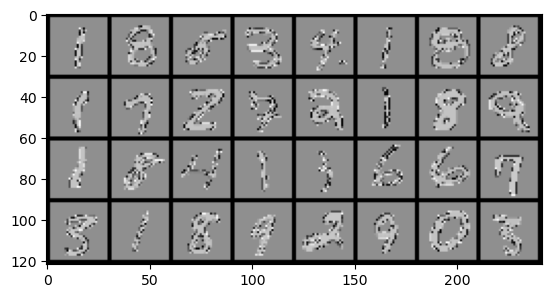

In [20]:
samples = iter(train_loader)

images, labels = next(samples)

img_grid = torchvision.utils.make_grid(images)

show(img_grid)

## Models

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 28*28),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )
        
    def forward(self, x):
        out = self.gen(x)
        
        return out
    

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # self.features = nn.Sequential(
        #     nn.Linear(784, 1024),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.Linear(1024, 512),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.Linear(512, 256),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.Linear(256, 2),
        #     nn.Sigmoid()
        # )
        
        self.disc = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        out = self.disc(x)
        
        return out
    
class GAN(nn.Module):
    def __init__(self):
        super(GAN, self).__init__()
        
    def forward(self, x):
        pass



## Training

In [22]:
G = Generator()
D = Discriminator()

In [23]:
fixed_noise = torch.randn((batch_size, 100)).to(device)

In [24]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=2e-3)
d_optimizer = torch.optim.Adam(D.parameters(), lr=2e-3)

# g_loss = nn.BCELoss()
# d_loss = nn.BCELoss()
criterion = nn.BCELoss()

writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")

step = 0

In [25]:
epochs = 1000
z_dim = 100

In [26]:
for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]
        
        ### Train Discriminator: max log(D(real)) + log(1 - D(g(z))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = G(noise)
        disc_real = D(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        
        disc_fake = D(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        lossD = (lossD_fake + lossD_real) / 2
        D.zero_grad()
        lossD.backward(retain_graph=True)
        d_optimizer.step()
        
        ### Train Generator min log(1-D(G(z))) <-> max log(D(G(z)))
        output = D(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        G.zero_grad()
        lossG.backward()
        g_optimizer.step()
        
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/ {epochs}] \ "
                f"Loss D: {lossD:.4f}, Loss G: {lossG:.4f}"
            )
            with torch.no_grad():
                fake = G(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)
                
                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                
                writer_fake.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                
                step +=1
                
                
        
        
        
        
        
        

Epoch [0/ 1000] \ Loss D: 0.6446, Loss G: 0.7822
Epoch [1/ 1000] \ Loss D: 0.3345, Loss G: 3.5086
Epoch [2/ 1000] \ Loss D: 0.0962, Loss G: 5.2660


KeyboardInterrupt: 